# Accurately predict used car prices using Carvana Aug 2022 data
## How accurately can we estimate the price of used cars using year & odometer

### Import libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.preprocessing import MinMaxScaler

### Import dataset

In [2]:
carvana = pd.read_csv('carvana_aug2008.csv')

### Exploratory Data Analysis - What does the data tell us

In [3]:
carvana.shape

(44365, 13)

In [5]:
carvana.columns

Index(['vehicle_id', 'stock_number', 'year', 'make', 'model', 'miles', 'trim',
       'sold_price', 'discounted_sold_price', 'partnered_dealership',
       'delivery_fee', 'earliest_delivery_date', 'sold_date'],
      dtype='object')

In [7]:
carvana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44365 entries, 0 to 44364
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   vehicle_id              44365 non-null  int64 
 1   stock_number            44365 non-null  int64 
 2   year                    44365 non-null  int64 
 3   make                    44365 non-null  object
 4   model                   44365 non-null  object
 5   miles                   44365 non-null  int64 
 6   trim                    44365 non-null  object
 7   sold_price              44365 non-null  int64 
 8   discounted_sold_price   44365 non-null  int64 
 9   partnered_dealership    44365 non-null  bool  
 10  delivery_fee            44365 non-null  int64 
 11  earliest_delivery_date  44365 non-null  object
 12  sold_date               44365 non-null  object
dtypes: bool(1), int64(7), object(5)
memory usage: 4.1+ MB


In [8]:
carvana.describe()

,vehicle_id,stock_number,year,miles,sold_price,discounted_sold_price,delivery_fee
count,4.436500e+04,4.436500e+04,44365.000000,44365.000000,44365.000000,44365.000000,44365.000000
mean,2.384957e+06,2.001808e+09,2016.440888,52744.110628,25273.599369,25273.599369,435.664600
std,1.009725e+05,1.517649e+05,2.953591,26644.532830,10594.087788,10594.087788,459.064815
min,1.278940e+06,2.000374e+09,2009.000000,0.000000,8990.000000,8990.000000,0.000000
25%,2.346460e+06,2.001743e+09,2014.000000,31968.000000,17990.000000,17990.000000,0.000000
50%,2.414320e+06,2.001853e+09,2017.000000,53062.000000,22585.000000,22585.000000,290.000000
75%,2.452565e+06,2.001914e+09,2019.000000,73005.000000,28990.000000,28990.000000,790.000000
max,2.510866e+06,2.002018e+09,2023.000000,115875.000000,129990.000000,129990.000000,1490.000000


In [9]:
# Car year ranges from 2009 to 2023, being data from Aug 2022, the 2023 model must be a new release
# Avg year of cars sold are 2016 with an avg 52,744 miles
# May need to dive deeper into what cars have zero miles, if not 2023 model
# Also may need to look at number of cars affecting min/max car price
# Dataset looks pretty clean with possibly no Nulls

In [11]:
# Check for Nulls
missing_values_count = pd.DataFrame({'Null': carvana.isnull().sum()})
total = len(carvana)
percentage_null = round((missing_values_count['Null']/total)*100,1)
missing_values_count['Percentage'] = percentage_null
missing_values_count.sort_values(by= 'Null' , ascending = False)

,Null,Percentage
vehicle_id,0,0.0
stock_number,0,0.0
year,0,0.0
make,0,0.0
model,0,0.0
miles,0,0.0
trim,0,0.0
sold_price,0,0.0
discounted_sold_price,0,0.0
partnered_dealership,0,0.0


In [12]:
# Wow, a clean dataset

In [15]:
# What columns do we want to drop that we don't need for price prediction or further analysis that might come to mind later
carvana.head()

,vehicle_id,stock_number,year,make,model,miles,trim,sold_price,discounted_sold_price,partnered_dealership,delivery_fee,earliest_delivery_date,sold_date
0,2270123,2001646447,2014,Volkswagen,Jetta,53238,2.0L S,15990,15990,False,1490,2022-09-09T21:34:31.376Z,8/31/2022
1,2298228,2001690283,2015,Chevrolet,Volt,112160,base,17590,17590,False,790,2022-09-09T22:04:42.555Z,8/31/2022
2,2463098,2001933427,2015,Ford,Focus,57046,SE,14990,14990,False,0,2022-09-06T21:35:20.3145311Z,8/31/2022
3,2488480,2001977729,2013,Honda,Odyssey,103874,EX-L,18990,18990,False,490,2022-09-06T22:04:19.711928Z,8/31/2022
4,2183400,2001531442,2015,Chevrolet,Cruze,86301,1LT,13990,13990,False,790,2022-09-09T22:05:19.367Z,8/31/2022


In [16]:
# We will drop vehicle id, stock #, discounted price, dealership, deliver fee and dates (since we know this is from Aug 2022)
# Keeping model and trim in case we want to use this data later
carvana.drop(['vehicle_id', 'stock_number', 'discounted_sold_price', 'partnered_dealership', 'delivery_fee', 'earliest_delivery_date', 'sold_date'], axis = 1, inplace = True)

In [17]:
carvana.head()

,year,make,model,miles,trim,sold_price
0,2014,Volkswagen,Jetta,53238,2.0L S,15990
1,2015,Chevrolet,Volt,112160,base,17590
2,2015,Ford,Focus,57046,SE,14990
3,2013,Honda,Odyssey,103874,EX-L,18990
4,2015,Chevrolet,Cruze,86301,1LT,13990


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'miles'}>],
       [<AxesSubplot:title={'center':'sold_price'}>, <AxesSubplot:>]],
      dtype=object)

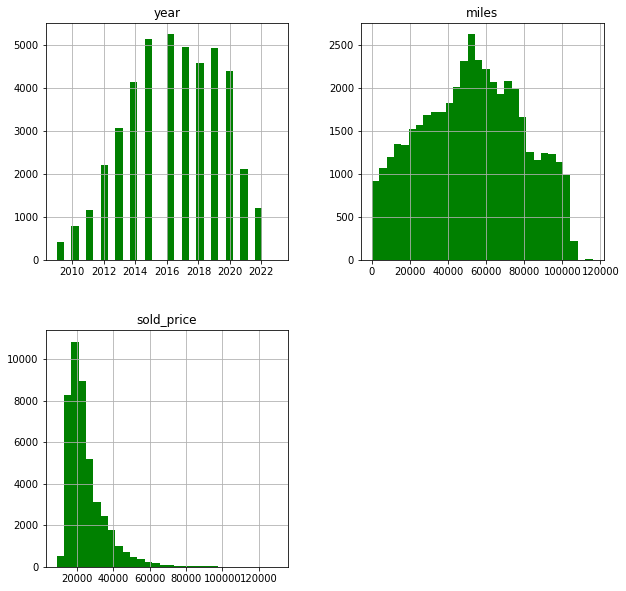

In [22]:
# How does the distribution of year, miles & sold price look
carvana.hist(bins= 30, figsize = (10,10), color = 'g')

In [31]:
# As we saw earlier, there is a big difference from max sold price and 75% percentile
# Since this dataset is fairly small and just a sample, showing on 1 month of sales, we will not remove sold price outliers

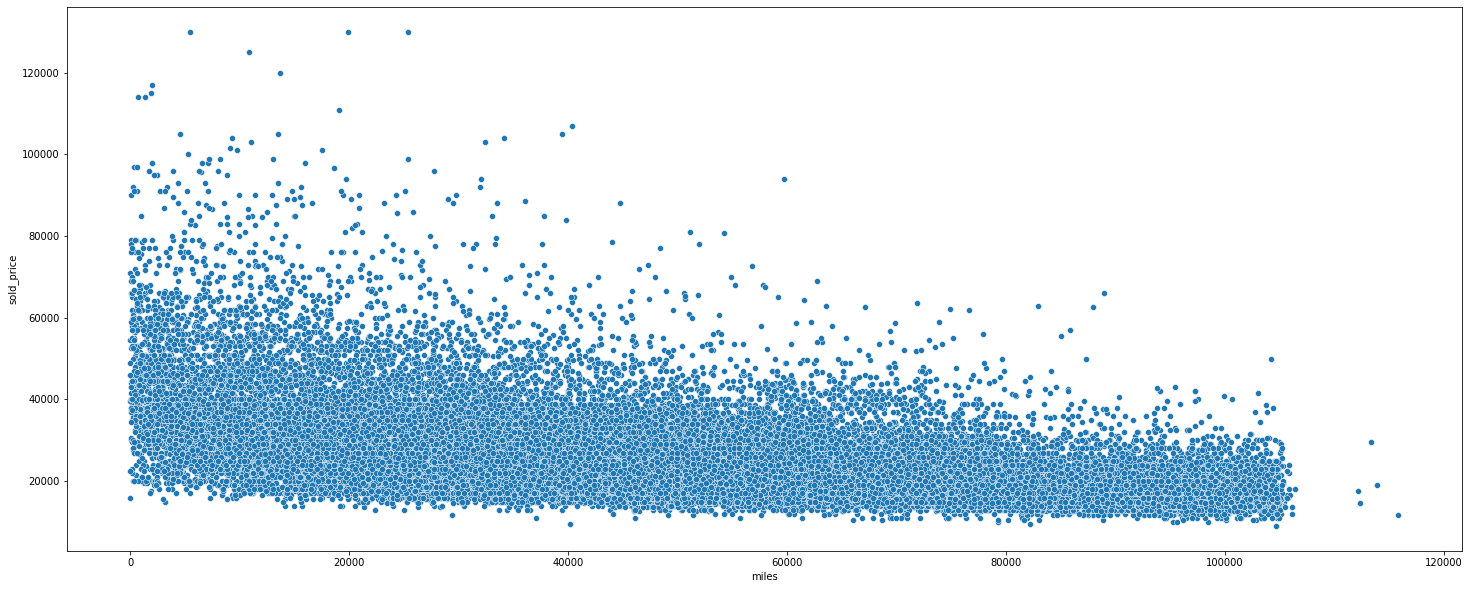

In [32]:
# Looking closer at miles to sold price, there looks to be 5 mile outliers above 110,000 miles
plt.figure(figsize=[25,10])
ax = sns.scatterplot(x = carvana['miles'], y= carvana['sold_price'])

In [33]:
# Since we know there are cars with stated zero miles, we will remove those along with the high outliers
carvana.drop(carvana[carvana["miles"]==0].index,inplace=True)

In [34]:
carvana=carvana[(carvana.miles < 110000)]

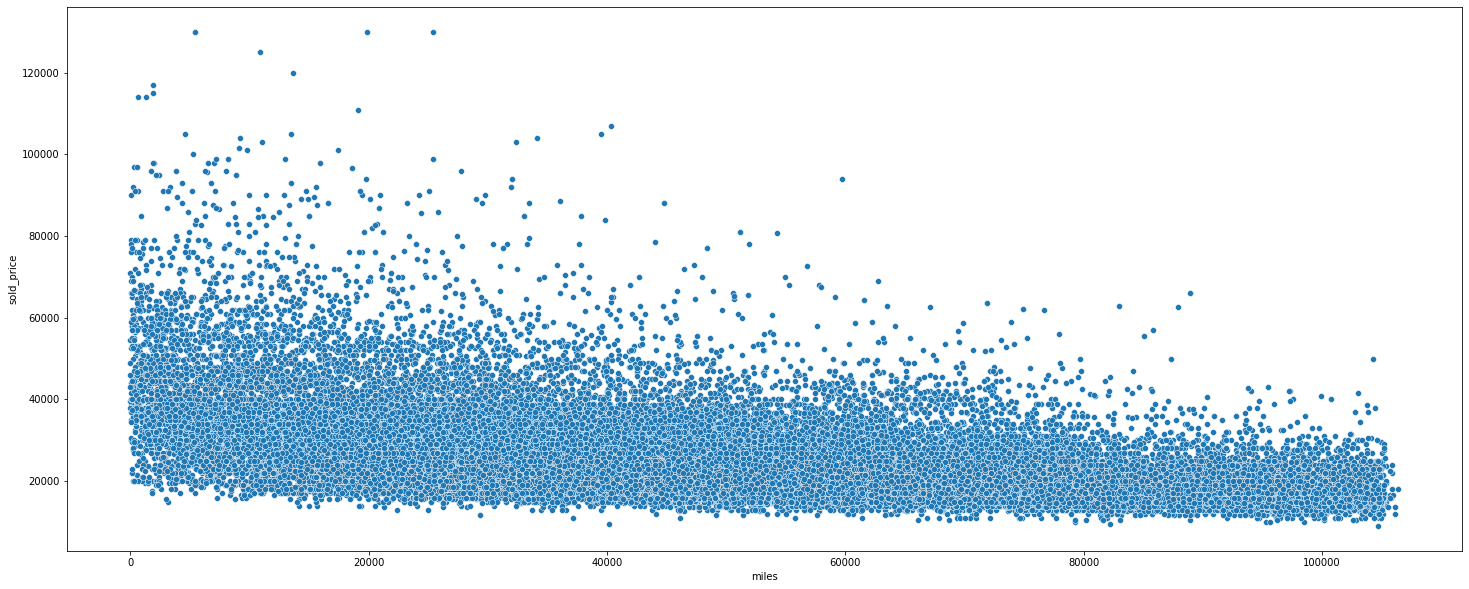

In [35]:
plt.figure(figsize=[25,10])
ax = sns.scatterplot(x = carvana['miles'], y= carvana['sold_price'])

## Change categorical data into numercial data for correlations and modeling

In [38]:
carvana.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44358 entries, 0 to 44364
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        44358 non-null  int64 
 1   make        44358 non-null  object
 2   model       44358 non-null  object
 3   miles       44358 non-null  int64 
 4   trim        44358 non-null  object
 5   sold_price  44358 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.4+ MB


In [39]:
print(carvana['make'].unique())

['Volkswagen' 'Ford' 'Honda' 'Chevrolet' 'Toyota' 'Mercedes-Benz' 'FIAT'
 'Cadillac' 'Hyundai' 'Chrysler' 'Dodge' 'Nissan' 'Kia' 'Mitsubishi' 'GMC'
 'Jeep' 'Audi' 'Subaru' 'MAZDA' 'Lexus' 'Porsche' 'BMW' 'Alfa Romeo'
 'Scion' 'Buick' 'Volvo' 'Land Rover' 'Lincoln' 'MINI' 'Ram' 'INFINITI'
 'Jaguar' 'Maserati' 'Acura' 'Tesla' 'smart' 'Genesis' 'Pontiac' 'Saturn'
 'Mercury' 'Saab' 'HUMMER' 'Polestar' 'Suzuki']


In [41]:
# Recode 'make' to numeric
def make_recode (series):
    if series == "Volkswagen":
        return 0
    if series == "Ford":
        return 1    
    if series == "Honda":
        return 2
    if series == "Chevrolet":
        return 3
    if series == "Toyota":
        return 4
    if series == "Mercedes-Benz":
        return 5
    if series == "FIAT":
        return 6
    if series == "Cadillac":
        return 7
    if series == "Hyundai":
        return 8
    if series == "Chrysler":
        return 9
    if series == "Dodge":
        return 10
    if series == "Nissan":
        return 11
    if series == "Kia":
        return 12
    if series == "Mitsubishi":
        return 13
    if series == "GMC":
        return 14
    if series == "Jeep":
        return 15
    if series == "Audi":
        return 16
    if series == "Subaru":
        return 17
    if series == "MAZDA":
        return 18
    if series == "Lexus":
        return 19
    if series == "Porsche":
        return 20
    if series == "BMW":
        return 21
    if series == "Alfa Romeo":
        return 22
    if series == "Scion":
        return 23
    if series == "Buick":
        return 24
    if series == "Volvo":
        return 25
    if series == "Land Rover":
        return 26
    if series == "Lincoln":
        return 27
    if series == "MINI":
        return 28
    if series == "Ram":
        return 29
    if series == "INFINITI":
        return 30
    if series == "Jaguar":
        return 31
    if series == "Maserati":
        return 32
    if series == "Acura":
        return 33
    if series == "Tesla":
        return 34
    if series == "smart":
        return 35
    if series == "Genesis":
        return 36
    if series == "Pontiac":
        return 37
    if series == "Saturn":
        return 38
    if series == "Mercury":
        return 39
    if series == "Saab":
        return 40
    if series == "HUMMER":
        return 41
    if series == "Polestar":
        return 42
    if series == "Suzuki":
        return 43

In [43]:
carvana['makeR'] = carvana['make'].apply(make_recode)

C:\Users\timca\AppData\Local\Temp\ipykernel_9496\3390018948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carvana['makeR'] = carvana['make'].apply(make_recode)


In [62]:
carvana.head()

,year,model,miles,trim,sold_price,makeR
0,2014,Jetta,53238,2.0L S,15990,0
2,2015,Focus,57046,SE,14990,1
3,2013,Odyssey,103874,EX-L,18990,2
4,2015,Cruze,86301,1LT,13990,3
5,2022,4Runner,5544,TRD Sport,48990,4


In [47]:
# Since model and trim categories have so many variables, trying a new function to me, Label Encoder
from sklearn.preprocessing import LabelEncoder

In [63]:
cat_features = ['model', 'trim']
encoder = LabelEncoder()
encoded = carvana[cat_features].apply(encoder.fit_transform)
carvana.drop(cat_features, axis = 1, inplace = True)
carvana = pd.concat([encoded,carvana], axis = 1)
carvana.head()

C:\Users\timca\AppData\Local\Temp\ipykernel_9496\1613053098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carvana.drop(cat_features, axis = 1, inplace = True)


,model,trim,year,miles,sold_price,makeR
0,277,52,2014,53238,15990,0
2,201,1131,2015,57046,14990,1
3,360,579,2013,103874,18990,2
4,142,39,2015,86301,13990,3
5,20,1395,2022,5544,48990,4


## Correlation Matrix

In [66]:
carvana.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,model,trim,year,miles,sold_price,makeR
model,1.0,0.21,0.077,-0.016,0.069,0.093
trim,0.21,1.0,0.063,-0.046,0.092,-0.0085
year,0.077,0.063,1.0,-0.57,0.53,-0.025
miles,-0.016,-0.046,-0.57,1.0,-0.55,-0.029
sold_price,0.069,0.092,0.53,-0.55,1.0,0.17
makeR,0.093,-0.0085,-0.025,-0.029,0.17,1.0


## Modeling - Random Forest Regressor

In [69]:
# Subset data for Train & Test set
list(carvana)

['model', 'trim', 'year', 'miles', 'sold_price', 'makeR']

In [72]:
X = carvana[['model', 'trim', 'year', 'miles', 'makeR']]
y = carvana[['sold_price']]

### Train Test Split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=13)

### Feature Scaling - important to apply when independent variables highly vary, like model and trim in this dataset
### Helps nomalize the range of variables

In [74]:
from sklearn.preprocessing import StandardScaler

In [76]:
sc_X = StandardScaler()

X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test)) 

X_train2.columns = X_train.columns.values 
X_test2.columns = X_test.columns.values 

X_train2.index = X_train.index.values
X_test2.index = X_test.index.values 

X_train = X_train2
X_test = X_test2

### Random Forest

In [84]:
forest = RandomForestRegressor(n_estimators=20, random_state=13)

In [85]:
acc = cross_val_score(forest, X_train, y_train, scoring='r2', cv=5)

C:\Python3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the

In [87]:
scores = []
scores.append(round(acc.mean()*100,2))

In [88]:
results = pd.DataFrame({
    'Metrics': ['R2'],
    'Accuracy': scores})
results

,Metrics,Accuracy
0,R2,88.17


### Hyper-parameter tuning

In [89]:
param_grid = {'n_estimators': [100, 200, 300]}
forest = RandomForestRegressor(random_state=13)
grid_search = GridSearchCV(estimator = forest, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [90]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\Python3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 300}

In [91]:
scores2 = []
best_grid = grid_search.best_estimator_
acc2 = cross_val_score(best_grid, X_train, y_train, scoring='r2', cv=5)
scores2.append(round(acc2.mean()*100,2))

C:\Python3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Python3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the

In [92]:
results = pd.DataFrame({
    'Metrics': ['R2'],
    'Accuracy': scores,
    'Accuracy Tuned Param': scores2})
results

,Metrics,Accuracy,Accuracy Tuned Param
0,R2,88.17,88.86


### Validation

In [93]:
from sklearn.metrics import r2_score

best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)
acc_test = round(r2_score(y_test,y_pred)*100,2)

In [94]:
results = pd.DataFrame({
    'Metrics': ['R2'],
    'Accuracy': scores,
    'Accuracy Tuned Param': scores2,
    'Accuracy Test Set': acc_test})
results

,Metrics,Accuracy,Accuracy Tuned Param,Accuracy Test Set
0,R2,88.17,88.86,88.48


## With a train set of 88.17% (which isn't bad) and even better test set of 88.48%, we were able to create a model to estimate the price of used cars.

## It would be interesting to see if it is as accurate with data that spans a full calendar year or even compare month to month depending on the season.